#Carga de librerias

In [1]:
!pip install requests    #Hacer llamadas http a paginas de la red
!pip install tsplib95    #Modulo para las instancias del problema del TSP

#Carga de los datos del problema

In [2]:
import urllib.request #Hacer llamadas http a paginas de la red
import tsplib95       #Modulo para las instancias del problema del TSP
import math           #Modulo de funciones matematicas. Se usa para exp
import random         #Para generar valores aleatorios


#http://elib.zib.de/pub/mp-testdata/tsp/tsplib/
#Documentacion :
  # http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/tsp95.pdf
  # https://tsplib95.readthedocs.io/en/stable/pages/usage.html
  # https://tsplib95.readthedocs.io/en/v0.6.1/modules.html
  # https://pypi.org/project/tsplib95/

#Descargamos el fichero de datos(Matriz de distancias)
file = "swiss42.tsp" ;
urllib.request.urlretrieve(f"http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/tsp/{file}.gz", file + '.gz')
!gzip -d swiss42.tsp.gz     #Descomprimir el fichero de datos

#Coordendas 51-city problem (Christofides/Eilon)
#file = "eil51.tsp" ; urllib.request.urlretrieve("http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/tsp/eil51.tsp.gz", file)

#Coordenadas - 48 capitals of the US (Padberg/Rinaldi)
#file = "att48.tsp" ; urllib.request.urlretrieve("http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/tsp/att48.tsp.gz", file)




swiss42.tsp already exists -- do you wish to overwrite (y or n)? ^C


In [7]:
#Carga de datos y generación de objeto problem
###############################################################################
problem = tsplib95.load(file)

#Nodos
Nodos = list(problem.get_nodes())


#Aristas
Aristas = list(problem.get_edges())



In [8]:
import math 

len(Aristas), len(Nodos) *  len(Nodos)



(1764, 1764)


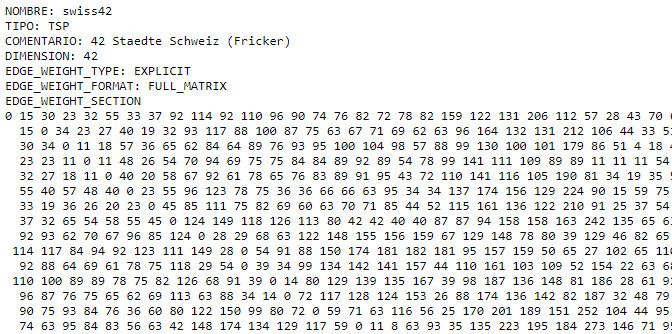

In [9]:
#Probamos algunas funciones del objeto problem

#Distancia entre nodos
problem.get_weight(0, 41)

#Todas las funciones
#Documentación: https://tsplib95.readthedocs.io/en/v0.6.1/modules.html

#dir(problem)

124

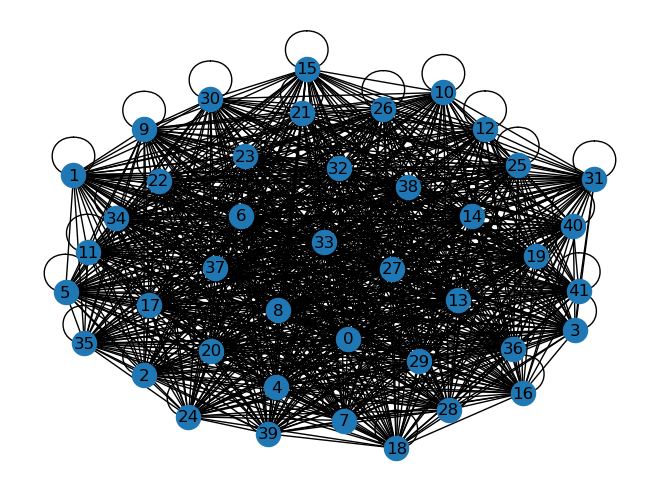

In [12]:
import networkx as nx
import matplotlib.pyplot as plt


G = nx.Graph()

# Add nodes to the graph
G.add_nodes_from(Nodos)

# Add connections to the graph
for from_node, to_node in Aristas:
    G.add_edge(from_node, to_node)

# Calculate positions for nodes
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True)

# # Add highlighted connections
# nx.draw_networkx_edges(G, pos, edgelist=selected, edge_color="r")

plt.show()

#Funcionas basicas


In [13]:

#Funcionas basicas
###############################################################################

#Se genera una solucion aleatoria con comienzo en en el nodo 0
def crear_solucion(Nodos):
  solucion = [Nodos[0]]
  for n in Nodos[1:]:
    solucion = solucion + [random.choice(list(set(Nodos) - set({Nodos[0]}) - set(solucion)))]
  return solucion

#Devuelve la distancia entre dos nodos
def distancia(a,b, problem):
  return problem.get_weight(a,b)

#Devuelve la distancia total de una trayectoria/solucion
def distancia_total(solucion, problem):
  distancia_total = 0
  for i in range(len(solucion)-1):
    distancia_total += distancia(solucion[i] ,solucion[i+1] ,  problem)
  return distancia_total + distancia(solucion[len(solucion)-1] ,solucion[0], problem)

sol_temporal = crear_solucion(Nodos)

distancia_total(sol_temporal, problem), sol_temporal

(4754,
 [0,
  39,
  26,
  40,
  33,
  41,
  8,
  35,
  37,
  25,
  9,
  38,
  6,
  21,
  20,
  13,
  10,
  12,
  31,
  23,
  27,
  14,
  32,
  29,
  15,
  16,
  17,
  34,
  28,
  7,
  1,
  18,
  24,
  11,
  22,
  30,
  2,
  3,
  5,
  36,
  19,
  4])

#BUSQUEDA ALEATORIA

In [27]:
###############################################################################
# BUSQUEDA ALEATORIA
###############################################################################


def busqueda_aleatoria(problem, N):
    # N es el numero de iteraciones
    Nodos = list(problem.get_nodes())

    mejor_solucion = []
    # mejor_distancia = 10e100                         #Inicializamos con un valor alto
    mejor_distancia = float("inf")  # Inicializamos con un valor alto

    for i in range(N):  # Criterio de parada: repetir N veces pero podemos incluir otros
        solucion = crear_solucion(Nodos)  # Genera una solucion aleatoria
        distancia = distancia_total(
            solucion, problem
        )  # Calcula el valor objetivo(distancia total)

        if distancia < mejor_distancia:  # Compara con la mejor obtenida hasta ahora
            mejor_solucion = solucion
            mejor_distancia = distancia

    print("Mejor solución:", mejor_solucion)
    print("Distancia     :", mejor_distancia)
    return mejor_solucion


# Busqueda aleatoria con 5000 iteraciones
solucion = busqueda_aleatoria(problem, 10000)

Mejor solución: [0, 13, 14, 20, 32, 34, 36, 17, 2, 27, 22, 23, 39, 24, 1, 30, 5, 35, 33, 10, 29, 28, 11, 12, 40, 9, 7, 31, 6, 16, 19, 37, 15, 38, 26, 3, 41, 25, 21, 18, 4, 8]
Distancia     : 3727


#BUSQUEDA LOCAL

In [39]:
###############################################################################
# BUSQUEDA LOCAL
###############################################################################
def genera_vecina(solucion):
  #Generador de soluciones vecinas: 2-opt (intercambiar 2 nodos) Si hay N nodos se generan (N-1)x(N-2)/2 soluciones
  #Se puede modificar para aplicar otros generadores distintos que 2-opt
  #print(solucion)
  mejor_solucion = []
  mejor_distancia = 10e100
  for i in range(1,len(solucion)-1):          #Recorremos todos los nodos en bucle doble para evaluar todos los intercambios 2-opt
    for j in range(i+1, len(solucion)):

      #Se genera una nueva solución intercambiando los dos nodos i,j:
      #  (usamos el operador + que para listas en python las concatena) : ej.: [1,2] + [3] = [1,2,3]
      vecina = solucion[:]
      vecina[i], vecina[j] = vecina[j], vecina[i]

      #Se evalua la nueva solución ...
      distancia_vecina = distancia_total(vecina, problem)

      #... para guardarla si mejora las anteriores
      if distancia_vecina <= mejor_distancia:
        mejor_distancia = distancia_vecina
        mejor_solucion = vecina
  return mejor_solucion

# solucion = [1, 47, 13, 41, 40, 19, 42, 44, 37, 5, 22, 28, 3, 2, 29, 21, 50, 34, 30, 9, 16, 11, 38, 49, 10, 39, 33, 45, 15, 24, 43, 26, 31, 36, 35, 20, 8, 7, 23, 48, 27, 12, 17, 4, 18, 25, 14, 6, 51, 46, 32]
print("Distancia Solucion Incial:" , distancia_total(solucion, problem))


nueva_solucion = genera_vecina(solucion)
print("Distancia Mejor Solucion Local:", distancia_total(nueva_solucion, problem))


Distancia Solucion Incial: 3727
Distancia Mejor Solucion Local: 3374


In [63]:
#Busqueda Local:
#  - Sobre el operador de vecindad 2-opt(funcion genera_vecina)
#  - Sin criterio de parada, se para cuando no es posible mejorar.
def busqueda_local(problem):
  mejor_solucion = []

  #Generar una solucion inicial de referencia(aleatoria)
  solucion_referencia = crear_solucion(Nodos)
  mejor_distancia = distancia_total(solucion_referencia, problem)

  iteracion=0             #Un contador para saber las iteraciones que hacemos
  while(1):
    iteracion +=1         #Incrementamos el contador
    #print('#',iteracion)

    #Obtenemos la mejor vecina ...
    vecina = genera_vecina(solucion_referencia)

    #... y la evaluamos para ver si mejoramos respecto a lo encontrado hasta el momento
    distancia_vecina = distancia_total(vecina, problem)

    #Si no mejoramos hay que terminar. Hemos llegado a un minimo local(según nuestro operador de vencindad 2-opt)
    if distancia_vecina < mejor_distancia:
      #mejor_solucion = copy.deepcopy(vecina)   #Con copia profunda. Las copias en python son por referencia
      mejor_solucion = vecina                   #Guarda la mejor solución encontrada
      mejor_distancia = distancia_vecina

    else:
      print("En la iteracion ", iteracion, ", la mejor solución encontrada es:" , mejor_solucion)
      print("Distancia     :" , mejor_distancia)
      return mejor_solucion

    solucion_referencia = vecina


sol = busqueda_local(problem )

En la iteracion  33 , la mejor solución encontrada es: [0, 16, 15, 37, 32, 20, 35, 36, 31, 17, 7, 18, 11, 12, 4, 3, 2, 27, 28, 30, 34, 33, 38, 22, 24, 40, 21, 29, 6, 14, 19, 13, 5, 26, 10, 8, 9, 39, 23, 41, 25, 1]
Distancia     : 1943


#SIMULATED ANNEALING


In [116]:
###############################################################################
# SIMULATED ANNEALING
###############################################################################

#Generador de 1 solucion vecina 2-opt 100% aleatoria (intercambiar 2 nodos)
#Mejorable eligiendo otra forma de elegir una vecina.
def genera_vecina_aleatorio(solucion):

  #Se eligen dos nodos aleatoriamente
  i,j = sorted(random.sample( range(1,len(solucion)) , 2))

  #Devuelve una nueva solución pero intercambiando los dos nodos elegidos al azar
  return solucion[:i] + [solucion[j]] + solucion[i+1:j] + [solucion[i]] + solucion[j+1:]


#Funcion de probabilidad para aceptar peores soluciones
def probabilidad(T,d):
  if random.random() <  math.exp( -1*d / T)  :
    return True
  else:
    return False

#Funcion de descenso de temperatura
def bajar_temperatura(T):
  return T*0.99

In [134]:
def recocido_simulado(problem, TEMPERATURA ):
  #problem = datos del problema
  #T = Temperatura

  solucion_referencia = crear_solucion(Nodos)
  distancia_referencia = distancia_total(solucion_referencia, problem)

  mejor_solucion = []             #x* del seudocodigo
  mejor_distancia = 10e100        #F* del seudocodigo


  N=0
  while TEMPERATURA > .0001:
    N+=1
    #Genera una solución vecina
    vecina =genera_vecina_aleatorio(solucion_referencia)

    #Calcula su valor(distancia)
    distancia_vecina = distancia_total(vecina, problem)

    #Si es la mejor solución de todas se guarda(siempre!!!)
    if distancia_vecina < mejor_distancia:
        mejor_solucion = vecina
        mejor_distancia = distancia_vecina

    #Si la nueva vecina es mejor se cambia
    #Si es peor se cambia según una probabilidad que depende de T y delta(distancia_referencia - distancia_vecina)
    if distancia_vecina < distancia_referencia or probabilidad(TEMPERATURA, abs(distancia_referencia - distancia_vecina) ) :
      #solucion_referencia = copy.deepcopy(vecina)
      solucion_referencia = vecina
      distancia_referencia = distancia_vecina

    #Bajamos la temperatura
    TEMPERATURA = bajar_temperatura(TEMPERATURA)

  print("La mejor solución encontrada es " , end="")
  print(mejor_solucion)
  print("con una distancia total de " , end="")
  print(mejor_distancia)
  print(N)
  return mejor_solucion

sol  = recocido_simulado(problem, 10000000)

La mejor solución encontrada es [0, 1, 28, 8, 10, 18, 26, 12, 11, 13, 14, 16, 15, 17, 7, 5, 19, 37, 31, 36, 35, 33, 38, 22, 23, 9, 41, 25, 27, 2, 3, 6, 4, 30, 29, 21, 40, 24, 39, 34, 32, 20]
con una distancia total de 2060
2521
